# Наша первая свёрточная нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [MNIST.](https://www.cs.toronto.edu/~kriz/cifar.html) Набор данных включает в себя изображения рукописных цифр.  

<img src="https://cdn-images-1.medium.com/max/1600/1*Riqqoa7vKHXnFHvaGfDFjA.png" style="width:90%">

In [1]:
# подгружаем пакеты
import numpy as np
import random
from tqdm import tqdm

import keras
from keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 1. Смотрим на данные 

Скачаеми приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ картинок размера $28 \times 28$.

In [2]:
from keras.datasets import mnist
(x_tr, y_tr), (x_ts, y_ts) = mnist.load_data()

In [3]:
print("Train samples:", x_tr.shape, y_tr.shape)
print("Test samples:", x_ts.shape, y_ts.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


Нарисуем несколько рандомных картинок из тренировочной выборки. 

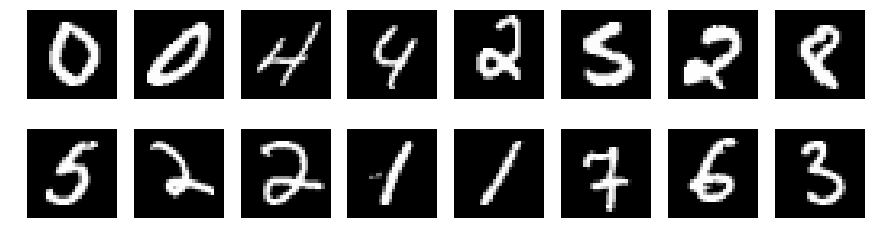

In [6]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_tr))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_tr[random_index, :], cmap = 'gray')
plt.show()

Отлично! Как вы помните, если пронормаровать данные, то сетка будет сходиться на порядок быстрее. 

Также, как вы помните из предыдущих скриптов, картинка - это тензор из циферок. Каждая циферка сообщает нам о яркости конкретного пикселя. Яркость измеряется по шкале от 0 до 255. В связи с этим фактом, нормализация будет немного странной: 

$$
x_{norm} = \frac{x}{255}
$$

In [7]:
# делай раз
x_train = x_tr/255
x_test =  x_ts/255

# Оставляем одну размерность на число каналов
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     

Также мы помним, что классы нужно конвертировать одним горячи кодированием (one-hot encoding) в набор из дамми-переменных. 

```
0 → [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 → [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 → [0, 0, 1, 0, 0, 0, 0, 0, 0]
3 → [0, 0, 0, 1, 0, 0, 0, 0, 0]
etc...
```

In [8]:
# делай два! 
y_train = keras.utils.to_categorical(y_tr,10)
y_test = keras.utils.to_categorical(y_ts,10)

# Размерность после конвертации будет вот такой: (?, NUM_CLASSES)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://keras.io/layers/convolutional/#conv2d) - Конволюция:
    - **filters**: число выходных каналов; 
    - **kernel_size**: размер окна для свёртки;
    - **padding**: padding="same" добавляет нулевую каёмку по краям картинки, чтбы после свёртки размеры картинки не изменялись; padding='valid' ничего не добавляет;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: размер входа
* [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - макспулинг
* [Flatten](https://keras.io/layers/core/#flatten) - разворачивает картинку в вектор 
* [Dense](https://keras.io/layers/core/#dense) - полносвязный слой (fully-connected layer)
* [Activation](https://keras.io/layers/core/#activation) - функция активации
* [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - leaky relu активация
* [Dropout](https://keras.io/layers/core/#dropout) - дропаут.


В модели, которую мы определим ниже, на вход будет идти тензоры размера __(None, 28, 28, 1)__ и __(None, 10)__. На выходе мы будем получать вероятноть того, что объект относится к конкретному классу. Разменость __None__ заготовлена для размерности батча. 

In [10]:
# подгружаем важные строительные блоки
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, InputLayer
from keras.layers.advanced_activations import LeakyReLU

### 2.1 Полносвязная сетка 

Соберём двухслойную полносвязную сетку: 

* Вход
* Развернём картинку в вектор 
* Полносвязный слой с 64 нейронами
* RELU 
* Полносвязный слой с 32 нейронами 
* Dropout с вероятностью 0.5 
* RELU 
* Полносвязный слой с 16 нейронами 
* Dropout с вероятностью 0.5 
* RELU 
* Слой с 10 нейронами для клссов, в качестве активации используйте Softmax

In [11]:
model_1 = Sequential( )

model_1.add(InputLayer([28, 28, 1]))
model_1.add(Flatten()) 

model_1.add(Dense(64))
model_1.add(Activation('relu'))

model_1.add(Dense(32))
model_1.add(Dropout(0.5))
model_1.add(Activation('relu'))

model_1.add(Dense(16))
model_1.add(Dropout(0.5))
model_1.add(Activation('relu'))

model_1.add(Dense(10, activation='softmax'))

model_1.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [12]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
__________

Можно визуализировать внутренними средствами keras сетку, которую мы собираем. 

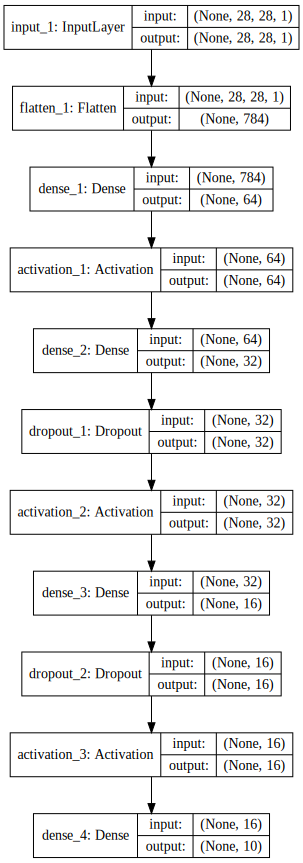

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_1, show_shapes=True).create(prog='dot', format='svg'))

In [14]:
hist = model_1.fit(x_train, y_train, validation_split=0.2, 
                   epochs=5, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 5s 109us/step - loss: 1.2179 - acc: 0.5621 - val_loss: 0.3744 - val_acc: 0.9250
Epoch 2/5
48000/48000 [==============================] - 5s 96us/step - loss: 0.8096 - acc: 0.7237 - val_loss: 0.2699 - val_acc: 0.9377
Epoch 3/5
48000/48000 [==============================] - 5s 96us/step - loss: 0.7091 - acc: 0.7608 - val_loss: 0.2355 - val_acc: 0.9465
Epoch 4/5
48000/48000 [==============================] - 5s 97us/step - loss: 0.6602 - acc: 0.7795 - val_loss: 0.2081 - val_acc: 0.9539
Epoch 5/5
48000/48000 [==============================] - 5s 102us/step - loss: 0.6243 - acc: 0.7900 - val_loss: 0.1986 - val_acc: 0.9553


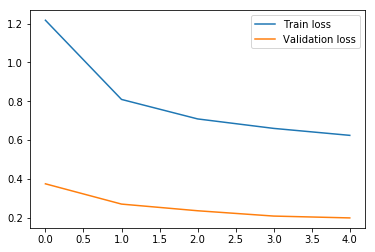

In [15]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [16]:
print("\nLoss, Accuracy = ", model_1.evaluate(x_test, y_test))

10000/10000 [==============================] - 0s 38us/step

Loss, Accuracy =  [0.20310979887247085, 0.955]


* Посмотрите на качество получившейся модели. Вернитесь по коду вверх и раскоментируйте строки, где картинки нормируются к отрезку $[0;1]$. Переобучите сетку. Что произошло с качеством? 
* Теперь попробуйте использовать в качестве функции активации линейную функцию. Что произошло с качеством модели?  

Можно посмотреть, где именно сетка ошибается. 

In [17]:
y_pred = model_1.predict_classes(x_test)
errors =  y_pred != y_ts

x_err = x_ts[errors]
y_err = y_ts[errors]
y_pred = y_pred[errors]

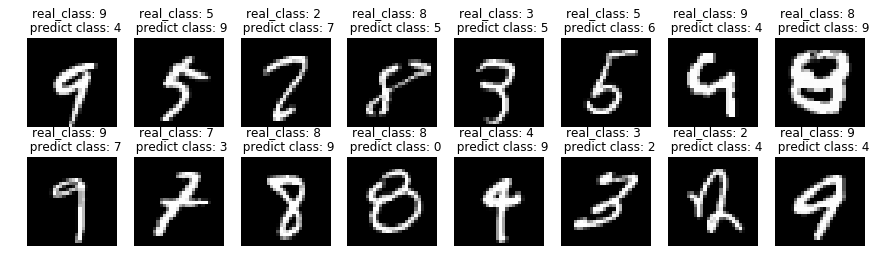

In [18]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred[random_index]))
plt.show()

### 2.2 Свёрточная сетка 

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и same padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше используйте старую архитектуру 

In [19]:
model_2 = Sequential( )

model_2.add(Conv2D(32, kernel_size=(5, 5),padding="same", 
                   input_shape=(28, 28, 1)))

model_2.add(Activation("relu"))
model_2.add(MaxPooling2D( pool_size=(2,2)))

model_2.add(Conv2D(16, kernel_size=(5, 5), padding="same"))
model_2.add(Activation("relu"))
model_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_2.add(Flatten()) 

model_2.add(Dense(64))
model_2.add(Activation('relu'))

model_2.add(Dense(32))
model_2.add(Dropout(0.5))
model_2.add(Activation('relu'))

model_2.add(Dense(16))
model_2.add(Dropout(0.5))
model_2.add(Activation('relu'))

model_2.add(Dense(10, activation='softmax'))
model_2.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [20]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        12816     
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
__________

In [21]:
# Прикажем модели останавливать обучение, когда качество на валидации не будет улучшаться в течение двух эпох
hist = model_2.fit(x_train, y_train, validation_split=0.2, 
                   epochs=5, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 79s 2ms/step - loss: 1.0554 - acc: 0.6055 - val_loss: 0.1386 - val_acc: 0.9724
Epoch 2/5
48000/48000 [==============================] - 75s 2ms/step - loss: 0.6154 - acc: 0.7768 - val_loss: 0.1036 - val_acc: 0.9763
Epoch 3/5
48000/48000 [==============================] - 60s 1ms/step - loss: 0.5318 - acc: 0.8081 - val_loss: 0.0912 - val_acc: 0.9818
Epoch 4/5
48000/48000 [==============================] - 69s 1ms/step - loss: 0.4844 - acc: 0.8339 - val_loss: 0.0832 - val_acc: 0.9857
Epoch 5/5
48000/48000 [==============================] - 67s 1ms/step - loss: 0.4600 - acc: 0.8434 - val_loss: 0.0854 - val_acc: 0.9841


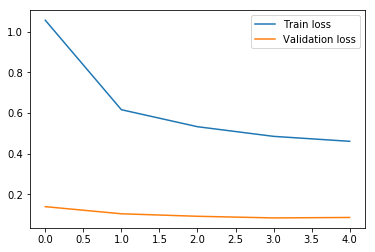

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [23]:
print("\nLoss, Accuracy = ", model_2.evaluate(x_test, y_test))

10000/10000 [==============================] - 5s 515us/step

Loss, Accuracy =  [0.06978304417692124, 0.9882]


Как видите, точность довольно сильно подскочила. Попробуйте поиграться числом параметров и слоёв так, чтобы их стало меньше, а качество сетки стало лучше. Попробуйте обучать нейросетку большее количество эпох. 

Снова посмотрим на ошибки. 

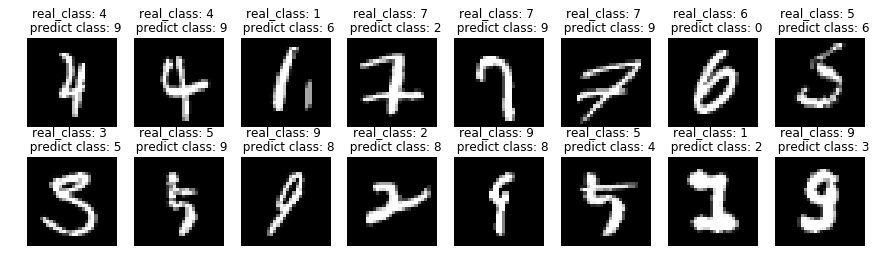

In [24]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_err[random_index, : ], cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred[random_index]))
plt.show()